In [1]:
#%%flake8  # checking PEP8 compliance
# Importation des diverses libraires
import re
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import researchpy as rp
from datetime import datetime, timedelta

from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import word2vec as w2v
import nltk
from nltk.corpus import stopwords
import string
from nltk.stem import WordNetLemmatizer, PorterStemmer, LancasterStemmer

import seaborn as sns
sns.set(style='white', context='notebook', palette='deep')


warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter("ignore")

pd.set_option('display.max_columns', 100)


%config InlineBackend.figure_format = 'png'
%matplotlib inline

G:\Logiciels\Anaconda\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
from sklearn.decomposition import LatentDirichletAllocation, NMF

from sklearn.model_selection import GridSearchCV, train_test_split, KFold

from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import MultiOutputClassifier, ClassifierChain
from sklearn.preprocessing import MultiLabelBinarizer

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

In [3]:
df = pd.read_hdf('dataframe_clean.h5')
it_tags_dict = pd.read_hdf('it_dict_syno.h5').values

In [4]:
# Number of words of the TF-IDF projection, we saw that 99% of the processed posts contain 546 words or less
tfidf_max_feat = 546

In [5]:
df.head(2)

,Tags_stripped,Text,Tags_in_IT_dict,Text_lemmatized,Text_stem_porter,Text_stem_lanca
0,"[visual studio, roslyn, debugging, c#]",debugging dll roslyn compilation roslyn csharp...,"[visual studio, debugging, c#]",debugging dll roslyn compilation roslyn csharp...,debugging dll roslyn compilation roslyn csharp...,debugging dll roslyn compilation roslyn csharp...
1,"[python, keras]",regularization keras regularization keras roug...,"[python, keras]",regularization keras regularization keras roug...,regularization keras regularization keras roug...,regularization keras regularization keras roug...


In [6]:
mlb = MultiLabelBinarizer(sparse_output=True)
mlb.fit(df["Tags_in_IT_dict"])

MultiLabelBinarizer(classes=None, sparse_output=True)

In [7]:
ytags = mlb.transform(df["Tags_in_IT_dict"])

In [8]:
y_t = pd.DataFrame(ytags.todense())

In [9]:
y_t["Sum"] = [x.sum() for _, x in y_t.iterrows()]

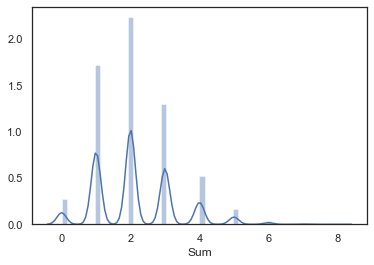

In [10]:
sns.distplot(y_t["Sum"])

In [11]:
# Removing posts without tags
df.drop(index=y_t[y_t["Sum"] == 0].index,
        inplace=True)

In [12]:
mlb = MultiLabelBinarizer(sparse_output=True)
mlb.fit(df["Tags_in_IT_dict"])

MultiLabelBinarizer(classes=None, sparse_output=True)

In [13]:
ytags = mlb.transform(df["Tags_in_IT_dict"])

In [14]:
y_t = pd.DataFrame(ytags.todense())

In [15]:
y_t["Sum"] = [x.sum() for _, x in y_t.iterrows()]

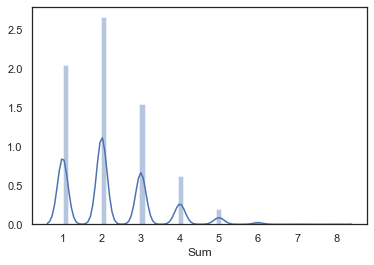

In [16]:
sns.distplot(y_t["Sum"])

In [17]:
y_t["Sum"].describe()

count    52639.000000
mean         2.221908
std          1.091478
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          8.000000
Name: Sum, dtype: float64

In [18]:
from sklearn.metrics import jaccard_score

In [19]:
def wstokenize(text):
    return nltk.WhitespaceTokenizer().tokenize(text)

In [20]:
def tagz_from_it(text, num_tag):
    # whitespace token
    wtext = wstokenize(text)
    temp = []
    for w in wtext:
        if w in it_tags_dict:
            temp.append(w)
    return list(pd.Series(temp).value_counts().index)[:num_tag]

In [177]:
xtext = df["Text"]
X_train, X_test, y_train, y_test = train_test_split(xtext,
                                                    ytags,
                                                    test_size=0.2,
                                                    random_state=42)

In [180]:
tag_it_1 = [tagz_from_it(text, 1) for text in X_train]
jaccard_score(mlb.transform(tag_it_1), y_train, average='micro')

0.22731263543301203

In [181]:
tag_it_2 = [tagz_from_it(text, 2) for text in X_train]
jaccard_score(mlb.transform(tag_it_2), y_train, average='micro')

0.30117524114422206

In [182]:
tag_it_3 = [tagz_from_it(text, 3) for text in X_train]
jaccard_score(mlb.transform(tag_it_3), y_train, average='micro')

0.3179238254698505

In [183]:
tag_it_4 = [tagz_from_it(text, 4) for text in X_train]
jaccard_score(mlb.transform(tag_it_4), y_train, average='micro')

0.3194385242889689

In [184]:
tag_it_5 = [tagz_from_it(text ,5) for text in X_train]
jaccard_score(mlb.transform(tag_it_5), y_train, average='micro')

0.3175519216569048

In [186]:
tag_it_1_t = [tagz_from_it(text, 1) for text in X_test]
jaccard_score(mlb.transform(tag_it_1_t), y_test, average='micro')

0.22674571310645003

In [187]:
tag_it_2_t = [tagz_from_it(text, 2) for text in X_test]
jaccard_score(mlb.transform(tag_it_2_t), y_test, average='micro')

0.2989649549039838

In [188]:
tag_it_3_t = [tagz_from_it(text, 3) for text in X_test]
jaccard_score(mlb.transform(tag_it_3_t), y_test, average='micro')

0.31560119653375274

In [189]:
tag_it_4_t = [tagz_from_it(text, 4) for text in X_test]
jaccard_score(mlb.transform(tag_it_4_t), y_test, average='micro')

0.31787825059101654

In [190]:
tag_it_5_t = [tagz_from_it(text, 5) for text in X_test]
jaccard_score(mlb.transform(tag_it_5_t), y_test, average='micro')

0.31622650213354864

In [21]:
tags_it_train_1 = 0.22731263543301203
tags_it_train_2 = 0.30117524114422206
tags_it_train_3 = 0.3179238254698505
tags_it_train_4 = 0.3194385242889689
tags_it_train_5 = 0.3175519216569048
tags_it_test_1 = 0.22674571310645003
tags_it_test_2 = 0.2989649549039838
tags_it_test_3 = 0.31560119653375274
tags_it_test_4 = 0.31787825059101654
tags_it_test_5 = 0.31622650213354864

In [29]:
tags_it_train = [tags_it_train_1*100,
                 tags_it_train_2*100,
                 tags_it_train_3*100,
                 tags_it_train_4*100,
                 tags_it_train_5*100]
tags_it_test = [tags_it_test_1*100,
                tags_it_test_2*100,
                tags_it_test_3*100,
                tags_it_test_4*100,
                tags_it_test_5*100]

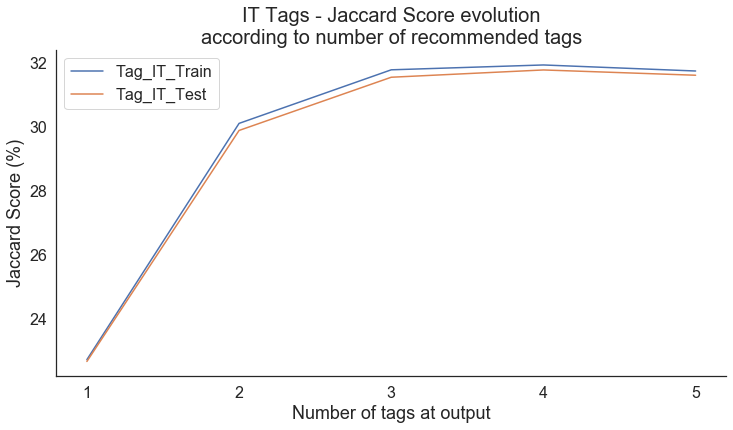

In [39]:
fig, ax = plt.subplots(figsize=(12, 6))
leg = ["Tag_IT_Train", "Tag_IT_Test"]
plt.plot(np.arange(5)+1, tags_it_train)
plt.plot(np.arange(5)+1, tags_it_test)
plt.ylabel("Jaccard Score (%)", fontsize=18)
plt.xlabel("Number of tags at output", fontsize=18)
plt.title("IT Tags - Jaccard Score evolution \
          \naccording to number of recommended tags",
          fontsize=20)
ax.tick_params(labelsize=16)
plt.xticks(np.arange(5)+1)
fig.patch.set_alpha(0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend(leg, fontsize=16)
plt.show()

In [19]:
xtext = df["Text_lemmatized"]

In [20]:
X_train, X_test, y_train, y_test = train_test_split(xtext,
                                                    ytags,
                                                    test_size=0.2,
                                                    random_state=42)

In [21]:
tfv = TfidfVectorizer(min_df=1,
                      max_features=tfidf_max_feat,
                      ngram_range=(1, 1))

In [22]:
tfv.fit(X_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=546,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [23]:
X_train_tfv = tfv.transform(X_train)
X_test_tfv = tfv.transform(X_test)

In [24]:
X_train_tfv

<42111x546 sparse matrix of type '<class 'numpy.float64'>'
	with 611793 stored elements in Compressed Sparse Row format>

In [25]:
y_train

<42111x275 sparse matrix of type '<class 'numpy.int32'>'
	with 93730 stored elements in Compressed Sparse Row format>

In [26]:
def GS_bestparam(model, search_grid, X_tr, X_te, y_tr, y_te):
    cross_validation = KFold(n_splits=5,
                             shuffle=True,
                             random_state=1)
    gridsearch = GridSearchCV(estimator=model,
                              param_grid=search_grid,
                              scoring="jaccard_micro",
                              refit=True,
                              cv=cross_validation,
                              n_jobs=6)
    print("{}".format(model))
    gridsearch.fit(X_tr, y_tr)
    print("Best params : {}".format(gridsearch.best_params_))
    print("Jaccard score - Training : {}".format(
        jaccard_score(gridsearch.predict(X_tr), y_tr, average="micro")))
    print("Jaccard score - Testing : {}".format(
        jaccard_score(gridsearch.predict(X_te), y_te, average="micro")))
    return gridsearch

In [27]:
lr_sg = [{'estimator__penalty': ['elasticnet'],
          'estimator__C': [1, 10],
          'estimator__solver': ['saga'],
          'estimator__l1_ratio': [0, 0.5, 1]}]

svm_sg = [{'estimator__penalty': ['l1', 'l2'],
           'estimator__C': [1, 10]}]

nbayes_sg = {'estimator__alpha': [0, 0.5, 1]}

In [28]:
def train_classifier(Xtr, Xte, ytr, yte, model, gridsearch):

    if model == 'lr':
        model = OneVsRestClassifier(LogisticRegression(),
                                    n_jobs=6)

    elif model == 'svm':
        model = OneVsRestClassifier(LinearSVC(),
                                    n_jobs=6)

    elif model == 'nbayes':
        model = OneVsRestClassifier(MultinomialNB(),
                                    n_jobs=6)

    elif model == 'mlp':
        model = OneVsRestClassifier(MLPClassifier(random_state=42,
                                                  hidden_layer_sizes=(10,)),
                                    n_jobs=6)
        model = model.fit(Xtr, ytr)
        print("Jaccard score - Training : {}".format(
            jaccard_score(model.predict(Xtr),
                          ytr,
                          average="micro")))
        print("Jaccard score - Testing : {}".format(
            jaccard_score(model.predict(Xte),
                          yte,
                          average="micro")))

    model = GS_bestparam(model,
                         gridsearch,
                         Xtr,
                         Xte,
                         ytr,
                         yte)

    return model

In [ ]:
clf_lr = train_classifier(X_train_tfv,
                          X_test_tfv,
                          y_train,
                          y_test,
                          'lr',
                          lr_sg)

In [ ]:
clf_svm = train_classifier(X_train_tfv,
                           X_test_tfv,
                           y_train,
                           y_test,
                           'svm',
                           svm_sg)

In [ ]:
clf_nb = train_classifier(X_train_tfv,
                          X_test_tfv,
                          y_train,
                          y_test,
                          'nbayes',
                          nbayes_sg)

In [ ]:
clf_mlp = train_classifier(X_train_tfv,
                           X_test_tfv,
                           y_train,
                           y_test,
                           'mlp',
                           None)

In [46]:
clf_lr = OneVsRestClassifier(LogisticRegression(C=10,
                                                l1_ratio=1,
                                                penalty='elasticnet',
                                                solver='saga',
                                                random_state=42),
                             n_jobs=6)
clf_svm = OneVsRestClassifier(LinearSVC(C=10,
                                        penalty='l2',
                                        random_state=42),
                             n_jobs=6)

clf_nb = OneVsRestClassifier(MultinomialNB(alpha=0),
                             n_jobs=6)

clf_mlp = OneVsRestClassifier(MLPClassifier(random_state=42,
                                            hidden_layer_sizes=(10,)),
                             n_jobs=6)

In [30]:
%time clf_mlp.fit(X_train_tfv, y_train) # >1H for 100 neurons

Wall time: 20min 17s


OneVsRestClassifier(estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                            batch_size='auto', beta_1=0.9,
                                            beta_2=0.999, early_stopping=False,
                                            epsilon=1e-08,
                                            hidden_layer_sizes=(10,),
                                            learning_rate='constant',
                                            learning_rate_init=0.001,
                                            max_fun=15000, max_iter=200,
                                            momentum=0.9, n_iter_no_change=10,
                                            nesterovs_momentum=True,
                                            power_t=0.5, random_state=42,
                                            shuffle=True, solver='adam',
                                            tol=0.0001, validation_fraction=0.1,
                                            verbos

In [1]:
print('MLP : {}'.format(jaccard_score(clf_mlp.predict(X_test_tfv),
                                      y_test,
                                      average='micro')))

UsageError: Cell magic `%%flake8` not found.


In [49]:
cols = ["Text_lemmatized",
        "Text_stem_porter",
        "Text_stem_lanca"]
df_res = pd.DataFrame(columns=cols)
df_res_train = pd.DataFrame(columns=cols)
for col in cols:
    print(col)
    xtext = df[col]
    X_train, X_test, y_train, y_test = train_test_split(xtext,
                                                        ytags,
                                                        test_size=0.2,
                                                        random_state=42)
    for i in range(3):
        print("N_Gram : (1, {})".format(i+1))
        tfv = TfidfVectorizer(min_df=1,
                              max_features=tfidf_max_feat,
                              ngram_range=(1, i+1))
        tfv.fit(X_train)
        X_train_tfv = tfv.transform(X_train)
        X_test_tfv = tfv.transform(X_test)
        # %time clf_mlp.fit(X_train_tfv,y_train)
        # print('MLP : {}'.format(jaccard_score(clf_mlp.predict(X_test_tfv), y_test, average='micro')))
        %time clf_lr.fit(X_train_tfv, y_train)
        print('Test : Logistic Regression : {}'.format(
            jaccard_score(clf_lr.predict(X_test_tfv),
                          y_test,
                          average='micro')))
        %time clf_svm.fit(X_train_tfv, y_train)
        print('Test : SVM Classifier : {}'.format(
            jaccard_score(clf_svm.predict(X_test_tfv),
                          y_test,
                          average='micro')))
        %time clf_nb.fit(X_train_tfv, y_train)
        print('Test : NB Multinominal : {}'.format(
            jaccard_score(clf_nb.predict(X_test_tfv),
                          y_test,
                          average='micro')))
        # col_mlp = str(i+1) + " MLP"
        col_lr = str(i+1) + " Logistic Regression"
        col_svm = str(i+1) + " SVM Classifier"
        col_nb = str(i+1) + " NB Multinominal"
        # df_res.at[col_mlp,col] = jaccard_score(clf_mlp.predict(X_test_tfv), y_test, average='micro')
        df_res.at[col_lr, col] = jaccard_score(
            clf_lr.predict(X_test_tfv),
            y_test,
            average='micro')
        df_res.at[col_svm, col] = jaccard_score(
            clf_svm.predict(X_test_tfv),
            y_test,
            average='micro')
        df_res.at[col_nb, col] = jaccard_score(
            clf_nb.predict(X_test_tfv),
            y_test,
            average='micro')

        df_res_train.at[col_lr, col] = jaccard_score(
            clf_lr.predict(X_train_tfv),
            y_train,
            average='micro')
        df_res_train.at[col_svm, col] = jaccard_score(
            clf_svm.predict(X_train_tfv),
            y_train,
            average='micro')
        df_res_train.at[col_nb, col] = jaccard_score(
            clf_nb.predict(X_train_tfv),
            y_train,
            average='micro')
    print("-------------")

Text_lemmatized
N_Gram : (1, 1)
Wall time: 6min 16s
Test : Logistic Regression : 0.38989846003971673
Wall time: 24.3 s
Test : SVM Classifier : 0.37676957831325303
Wall time: 1.16 s
Test : NB Multinominal : 0.24600778581075713
N_Gram : (1, 2)
Wall time: 6min 6s
Test : Logistic Regression : 0.3866596599226756
Wall time: 28.3 s
Test : SVM Classifier : 0.37528881481762055
Wall time: 952 ms
Test : NB Multinominal : 0.25172158891958135
N_Gram : (1, 3)
Wall time: 6min 3s
Test : Logistic Regression : 0.38659154929577466
Wall time: 25.4 s
Test : SVM Classifier : 0.37559237214239677
Wall time: 981 ms
Test : NB Multinominal : 0.2504849848684721
-------------
Text_stem_porter
N_Gram : (1, 1)
Wall time: 6min 24s
Test : Logistic Regression : 0.3893573168446693
Wall time: 23.9 s
Test : SVM Classifier : 0.3760725575794069
Wall time: 935 ms
Test : NB Multinominal : 0.24534075104311545
N_Gram : (1, 2)
Wall time: 6min 26s
Test : Logistic Regression : 0.38545850380991703
Wall time: 25.2 s
Test : SVM Class

In [51]:
df_res_train

,Text_lemmatized,Text_stem_porter,Text_stem_lanca
1 Logistic Regression,0.471466,0.471684,0.471255
1 SVM Classifier,0.487214,0.486296,0.486946
1 NB Multinominal,0.266104,0.265802,0.26592
2 Logistic Regression,0.464023,0.463307,0.463782
2 SVM Classifier,0.4758,0.47519,0.475423
2 NB Multinominal,0.270746,0.270562,0.270519
3 Logistic Regression,0.462503,0.46134,0.461806
3 SVM Classifier,0.47313,0.471359,0.472335
3 NB Multinominal,0.269474,0.268877,0.268963


In [52]:
df_res

,Text_lemmatized,Text_stem_porter,Text_stem_lanca
1 Logistic Regression,0.389898,0.389357,0.389759
1 SVM Classifier,0.37677,0.376073,0.377202
1 NB Multinominal,0.246008,0.245341,0.245859
2 Logistic Regression,0.38666,0.385459,0.387169
2 SVM Classifier,0.375289,0.374489,0.375109
2 NB Multinominal,0.251722,0.25179,0.251809
3 Logistic Regression,0.386592,0.385191,0.386657
3 SVM Classifier,0.375592,0.374223,0.374209
3 NB Multinominal,0.250485,0.250107,0.250252


In [50]:
df_res_train.sort_values(by="Text_lemmatized",
                         ascending=False)

,Text_lemmatized,Text_stem_porter,Text_stem_lanca
1 SVM Classifier,0.487214,0.486296,0.486946
2 SVM Classifier,0.4758,0.47519,0.475423
3 SVM Classifier,0.47313,0.471359,0.472335
1 Logistic Regression,0.471466,0.471684,0.471255
2 Logistic Regression,0.464023,0.463307,0.463782
3 Logistic Regression,0.462503,0.46134,0.461806
2 NB Multinominal,0.270746,0.270562,0.270519
3 NB Multinominal,0.269474,0.268877,0.268963
1 NB Multinominal,0.266104,0.265802,0.26592


In [31]:
df_res.sort_values(by="Text_lemmatized",
                   ascending=False)

,Text_lemmatized,Text_stem_porter,Text_stem_lanca
1 Logistic Regression,0.389898,0.389357,0.389759
2 Logistic Regression,0.38666,0.385459,0.387169
3 Logistic Regression,0.386592,0.385191,0.386657
1 SVM Classifier,0.37677,0.376073,0.377202
3 SVM Classifier,0.375592,0.374223,0.374209
2 SVM Classifier,0.375289,0.374489,0.375109
2 NB Multinominal,0.251722,0.25179,0.251809
3 NB Multinominal,0.250485,0.250107,0.250252
1 NB Multinominal,0.246008,0.245341,0.245859


In [32]:
for col in df_res.columns:
    print(col)
    print(df_res[col].astype('float64').idxmax()+" : "+str(df_res[col].max()))

Text_lemmatized
1 Logistic Regression : 0.38989846003971673
Text_stem_porter
1 Logistic Regression : 0.3893573168446693
Text_stem_lanca
1 Logistic Regression : 0.3897587653581061


In [33]:
xtext = df["Text_lemmatized"]
X_train, X_test, y_train, y_test = train_test_split(xtext,
                                                    ytags,
                                                    test_size=0.2,
                                                    random_state=42)
tfv = TfidfVectorizer(min_df=1,
                      max_features=tfidf_max_feat,
                      ngram_range=(1, 1))
tfv.fit(X_train)
X_train_tfv = tfv.transform(X_train)
X_test_tfv = tfv.transform(X_test)

In [34]:
supervised = clf_lr
supervised.fit(X_train_tfv, y_train)

OneVsRestClassifier(estimator=LogisticRegression(C=10, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=1, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None,
                                                 penalty='elasticnet',
                                                 random_state=42, solver='saga',
                                                 tol=0.0001, verbose=0,
                                                 warm_start=False),
                    n_jobs=6)

### LDA GridSearch

In [37]:
search_params = {'n_components': [6],
                 'learning_decay': [.5, .6, .7],
                 'learning_offset': [900, 1000, 1100],
                 'n_jobs': [1],
                 'evaluate_every': [-1],
                 'learning_method': ['online'],
                 'random_state': [42]
                 }

lda_sk = LatentDirichletAllocation()

model = GridSearchCV(cv=None,
                     error_score='raise',
                     estimator=lda_sk,
                     param_grid=search_params,
                     n_jobs=6,
                     scoring=None,
                     return_train_score=True,
                     verbose=1)

In [67]:
xtext = df["Text"]
X_train, X_test, y_train, y_test = train_test_split(xtext,
                                                    ytags,
                                                    test_size=0.2,
                                                    random_state=42)

In [68]:
from sklearn.feature_extraction.text import CountVectorizer
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2)
tf_vectorizer.fit(X_train)
X_train_tf = tf_vectorizer.transform(X_train)
X_test_tf = tf_vectorizer.transform(X_test)

In [40]:
model.fit(X_train_tf)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  45 out of  45 | elapsed: 13.3min finished


GridSearchCV(cv=None, error_score='raise',
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='batch',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1,
                                                 random_state=None,
                                                 topic_word_prior=None,
                                                 

In [41]:
best_lda_model = model.best_estimator_
print("Best params:\n{}".format(model.best_params_))
print("Best Log Likelihood Score: {}".format(model.best_score_))
print("Model perplexity: {}".format(best_lda_model.perplexity(X_train_tfv)))

Best params:
{'evaluate_every': -1, 'learning_decay': 0.6, 'learning_method': 'online', 'learning_offset': 1000, 'n_components': 6, 'n_jobs': 1, 'random_state': 42}
Best Log Likelihood Score: -159009.06996057119
Model perplexity: 815.228780665413


In [42]:
import pyLDAvis.sklearn

lda_display = pyLDAvis.sklearn.prepare(best_lda_model, X_train_tfv, tfv, mds='tsne', sort_topics=False)
pyLDAvis.display(lda_display)

In [69]:
lda_sk = LatentDirichletAllocation(evaluate_every=-1,
                                   learning_decay=.6,
                                   learning_method='online',
                                   learning_offset=1000,
                                   n_components=6,
                                   n_jobs=6,
                                   random_state=42)

In [70]:
lda_sk.fit(X_train_tf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.6,
                          learning_method='online', learning_offset=1000,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=6, n_jobs=6,
                          perp_tol=0.1, random_state=42, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [200]:
lda_output = lda_sk.transform(X_train_tf)

# column names
topicnames = ["Topic" + str(i+1) for i in range(lda_sk.n_components)]

# index names
docnames = ["Doc" + str(i+1) for i in range(X_train_tfv.shape[0])]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2),
                                 columns=topicnames,
                                 index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)+1
df_document_topic['dominant_topic'] = dominant_topic


# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)


def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)


# Apply Style
df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)

,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,dominant_topic
Doc1,0.200000,0.610000,0.000000,0.040000,0.110000,0.040000,2
Doc2,0.010000,0.010000,0.260000,0.180000,0.520000,0.010000,5
Doc3,0.000000,0.140000,0.060000,0.000000,0.300000,0.490000,6
Doc4,0.030000,0.010000,0.130000,0.360000,0.410000,0.060000,5
Doc5,0.000000,0.000000,0.510000,0.050000,0.440000,0.000000,3
Doc6,0.610000,0.070000,0.000000,0.310000,0.000000,0.000000,1
Doc7,0.000000,0.000000,0.000000,0.000000,0.280000,0.710000,6
Doc8,0.060000,0.000000,0.000000,0.190000,0.500000,0.240000,5
Doc9,0.000000,0.230000,0.390000,0.000000,0.270000,0.100000,3
Doc10,0.000000,0.980000,0.000000,0.000000,0.000000,0.000000,2


In [201]:
df_topic_distribution = df_document_topic['dominant_topic']\
    .value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,5,14851
1,2,8391
2,4,7950
3,1,5349
4,6,3051
5,3,2519


In [202]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(lda_sk.components_)

# Assign Column and Index
df_topic_keywords.columns = tf_vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

,aa,aaa,aaaa,aaaaa,aaaaaa,aaaaaaaa,aaaaaaaaaa,aaaab,aab,aaba,aabaa,aac,aad,aadb,aadhaar,aadinstance,aadsts,aae,aaed,aaf,aah,aal,aamir,aap,aapl,aapt,aaptoptions,aaptprocess,aaptv,aar,aarch,aaron,aars,aat,aatrox,aau,aazgjwfdmvna,ab,aba,abab,abacd,abandon,abandoned,abandoning,abarnert,abb,abbr,abbrev,abbreviate,abbreviated,...,zqu,zr,zrh,zs,zsh,zshrc,zst,zstack,zstart,zstd,zstl,zt,zts,zu,zug,zulu,zulufx,zusammenf,zuul,zv,zval,zw,zwei,zwh,zx,zxc,zxf,zxing,zxvf,zxy,zy,zygote,zygoteinit,zz,zza,zzb,zzd,zze,zzf,zzh,zzi,zzr,zzs,zzt,zzu,zzx,zzz,zzzz,zzzzzz,zzzzzzzz
Topic1,58.346030,89.258224,9.862696,0.166778,0.166858,0.167643,0.168304,0.167056,0.167390,0.166883,0.166926,0.169316,0.166744,0.187149,1.431517,0.166689,0.166808,0.166895,0.167369,0.166985,0.167617,4.488961,0.166667,0.168982,16.617599,0.166671,0.166671,0.166674,0.166667,0.166681,0.166785,0.169242,0.166667,0.167786,6.015475,4.888785,0.166884,68.371248,0.167035,0.166878,0.167725,13.969769,0.166824,0.167097,0.167086,3.270737,11.520182,9.543963,0.166959,1.471308,...,0.167920,0.170194,0.166961,42.697260,0.166739,0.166690,0.166806,0.167654,0.171047,0.167321,0.166747,8.186171,0.167647,0.170029,0.166893,0.166690,0.166880,2.755233,0.166671,0.178049,2.607334,0.167566,0.167903,0.166876,22.611067,0.167865,0.167223,0.166720,0.166740,3.442119,30.246744,0.166747,0.166679,20.388113,0.166756,0.166727,0.168861,0.166762,0.166741,0.167259,0.167072,0.167001,0.166667,0.166667,0.166670,0.166667,0.169056,0.168759,0.167013,0.169929
Topic2,31.596736,9.883314,0.168985,0.168203,0.167786,0.166667,0.167077,0.166745,3.420603,0.175774,0.166667,8.278658,0.168354,0.169626,0.167035,0.167040,0.169818,0.168668,1.476933,6.782137,0.166779,0.166865,0.166667,0.167993,0.166827,0.166729,0.166692,0.166793,0.166667,0.166776,0.167477,0.167285,0.167732,0.166667,0.166668,0.166668,0.166701,75.869996,4.098555,0.166984,0.166696,0.170944,0.179094,1.459760,0.167058,0.167717,0.170297,0.169770,0.170019,0.167240,...,2.960389,0.174618,2.414862,0.168396,30.654944,3.928181,0.166884,0.166723,0.166667,0.169309,0.166667,0.167094,5.800711,0.167942,0.166667,0.166888,0.166777,0.166667,13.019477,0.166997,0.166708,0.173808,0.170822,0.167077,0.169833,0.173809,0.171762,0.166699,2.857077,0.167158,0.167007,0.168177,0.166700,0.168905,0.166809,0.167236,0.167051,0.174097,0.166755,0.166891,0.167120,0.166891,0.167050,0.166801,0.166727,0.166919,0.168249,0.167098,3.649329,1.387362
Topic3,544.146978,0.168015,0.167498,0.167434,0.166749,7.705323,0.168127,9.831342,4.639824,0.167161,0.167583,21.683598,60.088136,8.078278,0.169240,10.681147,17.931291,10.957659,0.167281,0.168712,2.227588,0.171957,0.166667,0.170480,0.169720,0.166825,0.166789,0.166721,0.166670,0.166985,27.232146,0.166734,0.304476,0.167035,0.166669,0.181630,0.166785,248.053944,12.685961,0.166676,0.166799,0.287111,0.167133,0.168209,0.166667,27.891372,0.166999,0.167972,0.166878,0.169802,...,0.168242,4.307013,0.168023,3.381888,0.168645,0.167457,65.284687,0.166667,0.166681,1.651107,11.209645,0.184704,0.200636,0.177348,0.166892,25.599547,12.390680,0.167531,0.166800,5.584136,0.166908,9.104356,0.166667,0.923655,0.167137,0.169348,2.999467,0.167629,0.166667,0.166917,0.171557,6.691715,0.166748,0.168447,0.166696,0.166690,3.235994,0.166706,0.166696,0.166898,0.166825,0.166797,0.166667,0.166753,0.166667,0.166821,0.168288,0.167408,0.167030,0.172333
Topic4,0.167980,0.171067,8.337961,0.178158,0.168742,0.166734,0.166694,0.166667,0.167342,0.167829,0.166667,0.169003,0.166974,0.175658,0.166932,0.166667,0.166708,1.395107,0.170608,0.166720,0.203257,0.204397,2.568958,2.998267,0.169939,0.166730,0.166692,0.166742,0.166667,0.166756,0.166668,0.167441,0.168357,0.166694,0.168406,0.166695,16.142594,0.171649,0.169093,0.166672,0.166667,0.168307,0.167109,0.166743,0.166751,0.167902,0.171962,0.173613,0.166667,0.167699,...,0.168219,0.167136,0.167468,0.166927,0.166938,0.167449,0.166772,23.267009,4.733212,0.166689,0.166679,0.170864,0.167638,0.176104,5.745786,0.166671,0.166671,0.166881,0.166690,0.166684,0.166670,0.166753,0.167194,0.166

In [203]:
# Show top n keywords for each topic
def show_topics(vectorizer, lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        topic_words_in_it = []
        for ind in (-topic_weights).argsort():
            if len(topic_words_in_it) >= n_words:
                break
            else:
                if keywords[ind] in it_tags_dict:
                    topic_words_in_it.append(ind)
        top_keyword_locs = topic_words_in_it
        # top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords


topic_keywords = show_topics(vectorizer=tf_vectorizer,
                             lda_model=lda_sk,
                             n_words=15)

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i+1)
                             for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i+1)
                           for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,dataframe,pandas,python,numpy,keras,csv,random,datetime,excel,matplotlib,opencv,math,image,shiny,lstm
Topic 2,python,docker,php,json,apache,database,npm,git,django,logging,kubernetes,mysql,firebase,sql,ssl
Topic 3,windows,linux,azure,ruby,json,powershell,debugging,assembly,encryption,qt,xml,xamarin,macos,datetime,database
Topic 4,angular,html,flutter,css,reactjs,javascript,json,webpack,dart,bootstrap,jquery,typescript,svg,ios,rxjs
Topic 5,multithreading,python,templates,tensorflow,json,database,sql,sorting,javascript,pdf,regex,generics,woocommerce,csv,algorithm
Topic 6,java,android,gradle,spring,apache,maven,xml,kotlin,class,firebase,junit,api,hibernate,androidx,javafx


In [77]:
lda_output_test = lda_sk.transform(X_test_tf)

# column names
topicnames_test = ["Topic" + str(i+1)
                   for i in range(lda_sk.n_components)]

# index names
docnames_test = ["Doc" + str(i+1)
                 for i in range(X_test_tfv.shape[0])]

# Make the pandas dataframe
df_document_topic_test = pd.DataFrame(np.round(lda_output_test, 2),
                                      columns=topicnames_test,
                                      index=docnames_test)

# Get dominant topic for each document
dominant_topic_test = np.argmax(df_document_topic_test.values, axis=1)+1
df_document_topic_test['dominant_topic'] = dominant_topic_test

# Apply Style
df_document_topic_test.head(15).style.applymap(color_green).applymap(make_bold)

,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,dominant_topic
Doc1,0.010000,0.010000,0.010000,0.550000,0.390000,0.010000,4
Doc2,0.000000,0.130000,0.000000,0.770000,0.090000,0.000000,4
Doc3,0.000000,0.190000,0.000000,0.750000,0.050000,0.000000,4
Doc4,0.030000,0.960000,0.000000,0.000000,0.010000,0.000000,2
Doc5,0.110000,0.370000,0.000000,0.050000,0.000000,0.460000,6
Doc6,0.010000,0.010000,0.010000,0.010000,0.940000,0.010000,5
Doc7,0.230000,0.000000,0.080000,0.040000,0.640000,0.000000,5
Doc8,0.000000,0.630000,0.000000,0.000000,0.130000,0.240000,2
Doc9,0.000000,0.800000,0.000000,0.000000,0.190000,0.000000,2
Doc10,0.000000,0.980000,0.000000,0.000000,0.000000,0.000000,2


In [78]:
df_topic_distribution_test = df_document_topic_test['dominant_topic']\
    .value_counts().reset_index(name="Num Documents")
df_topic_distribution_test.columns = ['Topic Num', 'Num Documents']
df_topic_distribution_test

,Topic Num,Num Documents
0,5,3865
1,2,2058
2,4,1969
3,1,1275
4,6,765
5,3,596


In [128]:
def tagz_from_lda(text, num_tag):
    tagz_from_topics = \
        df_topic_keywords.iloc[np.argmax(lda_sk.transform(text))].values
    temp = []
    for w in it_tags_dict:
        if (len(temp) < num_tag) & (w in tagz_from_topics):
            temp.append(w)
    return (temp)

In [194]:
tag_topic_1_tr = [tagz_from_lda(text, 1) for text in X_train_tf]
jaccard_score(mlb.transform(tag_topic_1_tr), y_train, average='micro')

0.078086062125998

In [195]:
tag_topic_2_tr = [tagz_from_lda(text, 2) for text in X_train_tf]
jaccard_score(mlb.transform(tag_topic_2_tr), y_train, average='micro')

0.09757481558236498

In [196]:
tag_topic_3_tr = [tagz_from_lda(text, 3) for text in X_train_tf]
jaccard_score(mlb.transform(tag_topic_3_tr), y_train, average='micro')

0.09243309521800211

In [197]:
tag_topic_4_tr = [tagz_from_lda(text, 4) for text in X_train_tf]
jaccard_score(mlb.transform(tag_topic_4_tr), y_train, average='micro')

0.0880349932146696

In [198]:
tag_topic_5_tr = [tagz_from_lda(text, 5) for text in X_train_tf]
jaccard_score(mlb.transform(tag_topic_5_tr), y_train, average='micro')

0.08252960827074891

In [129]:
tag_topic_1 = [tagz_from_lda(text, 1) for text in X_test_tf]
jaccard_score(mlb.transform(tag_topic_1), y_test, average='micro')

0.0774312980753886

In [130]:
tag_topic_2 = [tagz_from_lda(text, 2) for text in X_test_tf]
jaccard_score(mlb.transform(tag_topic_2), y_test, average='micro')

0.09624477065128599

In [131]:
tag_topic_3 = [tagz_from_lda(text, 3) for text in X_test_tf]
jaccard_score(mlb.transform(tag_topic_3), y_test, average='micro')

0.09058893752487067

In [132]:
tag_topic_4 = [tagz_from_lda(text, 4) for text in X_test_tf]
jaccard_score(mlb.transform(tag_topic_4), y_test, average='micro')

0.08621062255839082

In [133]:
tag_topic_5 = [tagz_from_lda(text, 5) for text in X_test_tf]
jaccard_score(mlb.transform(tag_topic_5), y_test, average='micro')

0.0804933278265947

In [42]:
tags_lda_train_1 = 0.078086062125998
tags_lda_train_2 = 0.09757481558236498
tags_lda_train_3 = 0.09243309521800211
tags_lda_train_4 = 0.0880349932146696
tags_lda_train_5 = 0.08252960827074891
tags_lda_test_1 = 0.0774312980753886
tags_lda_test_2 = 0.09624477065128599
tags_lda_test_3 = 0.09058893752487067
tags_lda_test_4 = 0.08621062255839082
tags_lda_test_5 = 0.0804933278265947

In [43]:
tags_lda_train = [tags_lda_train_1*100,
                 tags_lda_train_2*100,
                 tags_lda_train_3*100,
                 tags_lda_train_4*100,
                 tags_lda_train_5*100]
tags_lda_test = [tags_lda_test_1*100,
                tags_lda_test_2*100,
                tags_lda_test_3*100,
                tags_lda_test_4*100,
                tags_lda_test_5*100]

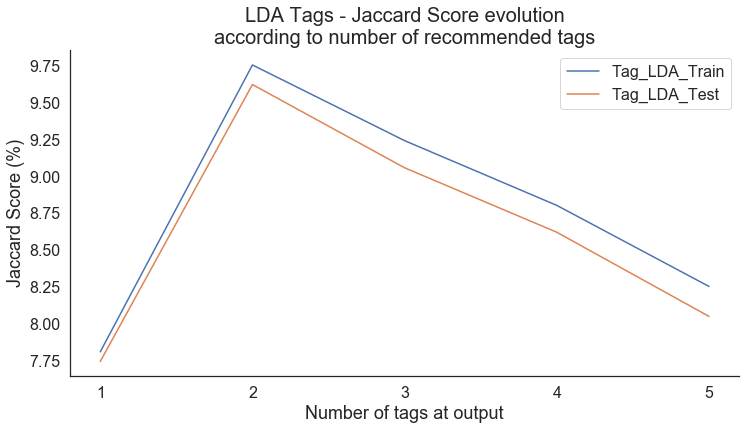

In [44]:
fig, ax = plt.subplots(figsize=(12, 6))
leg = ["Tag_LDA_Train", "Tag_LDA_Test"]
plt.plot(np.arange(5)+1, tags_lda_train)
plt.plot(np.arange(5)+1, tags_lda_test)
plt.ylabel("Jaccard Score (%)", fontsize=18)
plt.xlabel("Number of tags at output", fontsize=18)
plt.title("LDA Tags - Jaccard Score evolution\
    \naccording to number of recommended tags", fontsize=20)
ax.tick_params(labelsize=16)
plt.xticks(np.arange(5)+1)
fig.patch.set_alpha(0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend(leg, fontsize=16)
plt.show()

### Word2Vec implementation

In [62]:
import gensim

In [63]:
def wstokenize(text):
    return nltk.WhitespaceTokenizer().tokenize(text)

In [64]:
X_train, X_test, y_train, y_test = train_test_split(df["Text_lemmatized"],
                                                    ytags,
                                                    test_size=0.2,
                                                    random_state=42)

In [65]:
X_train_tokenized = X_train.apply(wstokenize)

In [66]:
model_w2v = gensim.models.Word2Vec(sentences=X_train_tokenized,
                                   workers=6,
                                   seed=42)

In [80]:
reco = []
for i, j in model_w2v.wv.most_similar("javascript", topn=len(it_tags_dict)):
    if i in it_tags_dict:
        reco.append(i)
reco

['jquery',
 'vue.js',
 'css',
 'ajax',
 'reactjs',
 'node.js',
 'html',
 'puppeteer',
 'svg',
 'axios',
 'typescript',
 'webpack']

In [54]:
xtext = df["Text_lemmatized"]
X_train, X_test, y_train, y_test = train_test_split(xtext,
                                                    ytags,
                                                    test_size=0.2,
                                                    random_state=42)
tfv = TfidfVectorizer(min_df=1,
                      max_features=tfidf_max_feat,
                      ngram_range=(1, 1))
tfv.fit(X_train)
X_train_tfv = tfv.transform(X_train)
X_test_tfv = tfv.transform(X_test)

### Fine-tuning predict_proba threshold

In [55]:
supervised = clf_lr
supervised.fit(X_train_tfv, y_train)

OneVsRestClassifier(estimator=LogisticRegression(C=10, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=1, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None,
                                                 penalty='elasticnet',
                                                 random_state=42, solver='saga',
                                                 tol=0.0001, verbose=0,
                                                 warm_start=False),
                    n_jobs=6)

In [139]:
threshold = [.01,
             .05,
             .1,
             .15,
             .2,
             .25,
             .3,
             .35,
             .4,
             .45,
             .5,
             .55,
             .6,
             .65,
             .7]
xtst_p = supervised.predict_proba(X_train_tfv)
for thrsh in threshold:
    xtst_p_bits = (xtst_p > thrsh).astype('int')
    print('Threshold {} : jaccard = {}'.format(
        thrsh,
        jaccard_score(xtst_p_bits,
                      y_train,
                      average='micro')))

Threshold 0.01 : jaccard = 0.1239117024788022
Threshold 0.05 : jaccard = 0.3149252615844544
Threshold 0.1 : jaccard = 0.4364612013260662
Threshold 0.15 : jaccard = 0.49649109594199525
Threshold 0.2 : jaccard = 0.5237179684375672
Threshold 0.25 : jaccard = 0.5313939233292468
Threshold 0.3 : jaccard = 0.5293279858799269
Threshold 0.35 : jaccard = 0.5207687764096506
Threshold 0.4 : jaccard = 0.5072737825541556
Threshold 0.45 : jaccard = 0.49054090316644944
Threshold 0.5 : jaccard = 0.4714655214484408
Threshold 0.55 : jaccard = 0.45173408399329956
Threshold 0.6 : jaccard = 0.43108051145145426
Threshold 0.65 : jaccard = 0.40817237008871987
Threshold 0.7 : jaccard = 0.3847310288402536


In [140]:
threshold = [.01,
             .05,
             .1,
             .15,
             .2,
             .25,
             .3,
             .35,
             .4,
             .45,
             .5,
             .55,
             .6,
             .65,
             .7]
xtst_p = supervised.predict_proba(X_test_tfv)
for thrsh in threshold:
    xtst_p_bits = (xtst_p > thrsh).astype('int')
    print('Threshold {} : jaccard = {}'.format(
        thrsh,
        jaccard_score(xtst_p_bits,
                      y_test,
                      average='micro')))

Threshold 0.01 : jaccard = 0.10422246522660158
Threshold 0.05 : jaccard = 0.24026422163068126
Threshold 0.1 : jaccard = 0.32439415723781545
Threshold 0.15 : jaccard = 0.36886971964987947
Threshold 0.2 : jaccard = 0.3922549299799943
Threshold 0.25 : jaccard = 0.40264925257652195
Threshold 0.3 : jaccard = 0.4069553805774278
Threshold 0.35 : jaccard = 0.4063732720474737
Threshold 0.4 : jaccard = 0.4038365896980462
Threshold 0.45 : jaccard = 0.3965189410560187
Threshold 0.5 : jaccard = 0.38989846003971673
Threshold 0.55 : jaccard = 0.3805407886181971
Threshold 0.6 : jaccard = 0.3692385549672999
Threshold 0.65 : jaccard = 0.3568041725936463
Threshold 0.7 : jaccard = 0.3427976452685115


In [141]:
threshold = np.arange(.25,.36,.01)
xtst_p = supervised.predict_proba(X_train_tfv)
for thrsh in threshold:
    xtst_p_bits = (xtst_p > thrsh).astype('int')
    print('Threshold {} : jaccard = {}'.format(
        thrsh,
        jaccard_score(xtst_p_bits,
                      y_train,
                      average='micro')))

Threshold 0.25 : jaccard = 0.5313939233292468
Threshold 0.26 : jaccard = 0.5315078832606508
Threshold 0.27 : jaccard = 0.5314750566220194
Threshold 0.28 : jaccard = 0.5311787202661682
Threshold 0.29000000000000004 : jaccard = 0.5303174630665581
Threshold 0.30000000000000004 : jaccard = 0.5293279858799269
Threshold 0.31000000000000005 : jaccard = 0.5283700758944705
Threshold 0.32000000000000006 : jaccard = 0.5269100154685916
Threshold 0.33000000000000007 : jaccard = 0.5246776982413388
Threshold 0.3400000000000001 : jaccard = 0.5228993511474492
Threshold 0.3500000000000001 : jaccard = 0.5207687764096506


In [142]:
threshold = np.arange(.25,.36,.01)
xtst_p = supervised.predict_proba(X_test_tfv)
for thrsh in threshold:
    xtst_p_bits = (xtst_p > thrsh).astype('int')
    print('Threshold {} : jaccard = {}'.format(
        thrsh,
        jaccard_score(xtst_p_bits,
                      y_train,
                      average='micro')))

Threshold 0.25 : jaccard = 0.40264925257652195
Threshold 0.26 : jaccard = 0.4037393732157982
Threshold 0.27 : jaccard = 0.4042897483897579
Threshold 0.28 : jaccard = 0.40567430515437447
Threshold 0.29000000000000004 : jaccard = 0.4056964899759943
Threshold 0.30000000000000004 : jaccard = 0.4069553805774278
Threshold 0.31000000000000005 : jaccard = 0.4067684360409285
Threshold 0.32000000000000006 : jaccard = 0.40646821021683205
Threshold 0.33000000000000007 : jaccard = 0.4067424830425539
Threshold 0.3400000000000001 : jaccard = 0.4064434918690889
Threshold 0.3500000000000001 : jaccard = 0.4063732720474737


In [71]:
threshold = np.arange(.260,.270,.001)
xtst_p = supervised.predict_proba(X_train_tfv)
for thrsh in threshold:
    xtst_p_bits = (xtst_p > thrsh).astype('int')
    print('Threshold {} : jaccard = {}'.format(
        thrsh,
        jaccard_score(xtst_p_bits,
                      y_train,
                      average='micro')))

Threshold 0.26 : jaccard = 0.5315078832606508
Threshold 0.261 : jaccard = 0.5314803310891355
Threshold 0.262 : jaccard = 0.5316298226443641
Threshold 0.263 : jaccard = 0.5316302317362549
Threshold 0.264 : jaccard = 0.5317705744065926
Threshold 0.265 : jaccard = 0.5318569138614697
Threshold 0.266 : jaccard = 0.5317253202935637
Threshold 0.267 : jaccard = 0.5316447134813412
Threshold 0.268 : jaccard = 0.5317171443565999
Threshold 0.269 : jaccard = 0.5316172545563925
Threshold 0.27 : jaccard = 0.5314750566220194


In [72]:
threshold = np.arange(.295,.305,.001)
xtst_p = supervised.predict_proba(X_test_tfv)
for thrsh in threshold:
    xtst_p_bits = (xtst_p > thrsh).astype('int')
    print('Threshold {} : jaccard = {}'.format(
        thrsh,
        jaccard_score(xtst_p_bits,
                      y_train,
                      average='micro')))

Threshold 0.295 : jaccard = 0.4067243349110495
Threshold 0.296 : jaccard = 0.4069535666437931
Threshold 0.297 : jaccard = 0.4069215923587714
Threshold 0.298 : jaccard = 0.4069938770832651
Threshold 0.299 : jaccard = 0.40683687850283506
Threshold 0.3 : jaccard = 0.4069553805774278
Threshold 0.301 : jaccard = 0.4069099149397353
Threshold 0.302 : jaccard = 0.40690833798928583
Threshold 0.303 : jaccard = 0.40716612377850164
Threshold 0.304 : jaccard = 0.40700240440038205
Threshold 0.305 : jaccard = 0.4069495269178782


In [56]:
xtst_p_bits = (supervised.predict_proba(X_train_tfv) > 0.265).astype('int')
print('Threshold {} : jaccard = {}'.format(0.265,
                                           jaccard_score(xtst_p_bits,
                                                         y_train,
                                                         average='micro')))

Threshold 0.265 : jaccard = 0.5318569138614697


In [57]:
xtst_p_bits = (supervised.predict_proba(X_test_tfv) > 0.265).astype('int')
print('Threshold {} : jaccard = {}'.format(0.265,
                                           jaccard_score(xtst_p_bits,
                                                         y_train,
                                                         average='micro')))

Threshold 0.265 : jaccard = 0.4037539432176656


Num Words 1 : jaccard = 0.5316093858747887

In [167]:
threshold = 0.265
num_w = [2, 3, 4, 5]
for num in num_w:
    xtst_p_bits = []
    for ind in range(len(X_train)):
        threshold = 0.265
        xtst_p = clf_lr.predict_proba(X_train_tfv[ind])
        xtst_p = (xtst_p > threshold).astype('int')
        if np.sum(xtst_p) < 1:
            threshold = np.sort(clf_lr.predict_proba(X_train_tfv[ind]))[0][-num]-1e-10
            xtst_p = clf_lr.predict_proba(X_train_tfv[ind])
            xtst_p = (xtst_p > threshold).astype('int')
        xtst_p_bits.append(xtst_p[0])
    print('Num Words {} : jaccard = {}'.format(
        num,
        jaccard_score(np.array(xtst_p_bits),
                      y_train,
                      average='micro')))

Num Words 2 : jaccard = 0.5275037551252385
Num Words 3 : jaccard = 0.5208482306017702
Num Words 4 : jaccard = 0.5126129415694897
Num Words 5 : jaccard = 0.5039806135006609


In [48]:
threshold = 0.265
num_w = [1,
         2,
         3,
         4,
         5]
for num in num_w:
    xtst_p_bits = []
    for ind in range(len(X_test)):
        threshold = 0.265
        xtst_p = clf_lr.predict_proba(X_test_tfv[ind])
        xtst_p = (xtst_p > threshold).astype('int')
        if np.sum(xtst_p) < 1:
            threshold = np.sort(clf_lr.predict_proba(X_test_tfv[ind]))[0][-num]-1e-10
            xtst_p = clf_lr.predict_proba(X_test_tfv[ind])
            xtst_p = (xtst_p > threshold).astype('int')
        xtst_p_bits.append(xtst_p[0])
    print('Num Words {} : jaccard = {}'.format(
        num,
        jaccard_score(np.array(xtst_p_bits),
                      y_test,
                      average='micro')))

Num Words 1 : jaccard = 0.4013471534463138
Num Words 2 : jaccard = 0.39654346133109686
Num Words 3 : jaccard = 0.3895104895104895
Num Words 4 : jaccard = 0.38155694731770906
Num Words 5 : jaccard = 0.3734215605183347


In [58]:
tags_lr_train_1 = 0.5316093858747887
tags_lr_train_2 = 0.5275037551252385
tags_lr_train_3 = 0.5208482306017702
tags_lr_train_4 = 0.5126129415694897
tags_lr_train_5 = 0.5039806135006609
tags_lr_test_1 = 0.4013471534463138
tags_lr_test_2 = 0.39654346133109686
tags_lr_test_3 = 0.3895104895104895
tags_lr_test_4 = 0.38155694731770906
tags_lr_test_5 = 0.3734215605183347

In [59]:
tags_lr_train = [tags_lr_train_1*100,
                 tags_lr_train_2*100,
                 tags_lr_train_3*100,
                 tags_lr_train_4*100,
                 tags_lr_train_5*100]
tags_lr_test = [tags_lr_test_1*100,
                tags_lr_test_2*100,
                tags_lr_test_3*100,
                tags_lr_test_4*100,
                tags_lr_test_5*100]

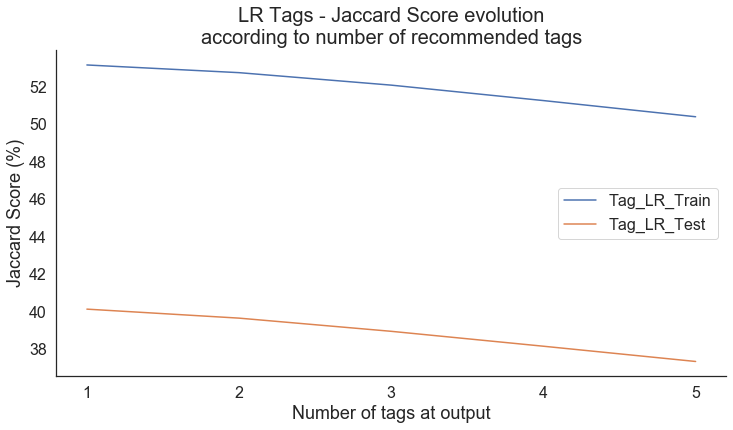

In [61]:
fig, ax = plt.subplots(figsize=(12, 6))
leg = ["Tag_LR_Train", "Tag_LR_Test"]
plt.plot(np.arange(5)+1,tags_lr_train)
plt.plot(np.arange(5)+1,tags_lr_test)
plt.ylabel("Jaccard Score (%)", fontsize=18)
plt.xlabel("Number of tags at output", fontsize=18)
plt.title("LR Tags - Jaccard Score evolution\
    \naccording to number of recommended tags", fontsize=20)
ax.tick_params(labelsize=16)
plt.xticks(np.arange(5)+1)
fig.patch.set_alpha(0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend(leg, fontsize=16)
plt.show()

In [103]:
from scipy import sparse

In [88]:
supervised

OneVsRestClassifier(estimator=LogisticRegression(C=10, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=1, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None,
                                                 penalty='elasticnet',
                                                 random_state=42, solver='saga',
                                                 tol=0.0001, verbose=0,
                                                 warm_start=False),
                    n_jobs=6)

In [113]:
X_train.iloc[1]

'interface typescript scenario require passwords typescript strong typed send written interface userlogin userlogin scenario'

In [112]:
mlb.inverse_transform(y_train[1])

[('typescript', 'class')]

In [114]:
#count_vect
text_cv = tf_vectorizer.transform([X_train.iloc[1]])
#tfv
text_tfv = tfv.transform([X_train_l.iloc[1]])
#whitespace token
wtext = wstokenize(X_train.iloc[1])

#tagz_from_model
threshold = 0.265
tagz_from_model = supervised.predict_proba(text_tfv)
tagz_from_model = (tagz_from_model>threshold).astype('int')
if np.sum(tagz_from_model) < 1:
    threshold = np.sort(supervised.predict_proba(text_tfv))[0][-1]-1e-10
    tagz_from_model = supervised.predict_proba(text_tfv)
    tagz_from_model = (tagz_from_model>threshold).astype('int')
tagz_from_model = mlb.inverse_transform(sparse.csr_matrix(tagz_from_model))[0]
print(tagz_from_model)

('typescript',)


### Hybrid Tagging trials

In [212]:
# Using Weighted IT_dict & LDA for the remaining unpredicted
def taggingv3(text, text_lem, number_of_tags):
    #count_vect
    text_cv = tf_vectorizer.transform([text])
    #tfv
    text_tfv = tfv.transform([text_lem])
    #whitespace token
    wtext = wstokenize(text_lem)
    
    #tagz_from_model
    threshold = 0.265
    tagz_from_model = supervised.predict_proba(text_tfv)
    tagz_from_model = (tagz_from_model>threshold).astype('int')
    
    if np.sum(tagz_from_model) < 1:
        rez = pd.DataFrame(index=["tag","value"])
        #tagz_from_it
        tagz_from_it = list([words for words in wtext if words in it_tags_dict])
        if len(tagz_from_it) > 0:
            for tag in tagz_from_it:
                ind = rez.shape[1]
                rez.at["tag",ind] = tag
                rez.at["value",ind] = 0.3194
                
        #tagz_from_topics
        tagz_from_topics = df_topic_keywords.iloc[np.argmax(lda_sk.transform(text_cv))].values
        temp = []
        for w in it_tags_dict:
            if w in tagz_from_topics:
                temp.append(w)
        tagz_from_topics = temp
        for n, tag in enumerate(tagz_from_topics):
            ind = rez.shape[1]
            rez.at["tag",ind] = tag
            rez.at["value",ind] = 0.0976 - 1e-5*n
            
        return(list(rez.T.groupby("tag").sum().sort_values(by="value",ascending=False).index)[:number_of_tags])
    else:    
        tagz_from_model = mlb.inverse_transform(sparse.csr_matrix(tagz_from_model))[0]
        return(tagz_from_model)

In [213]:
num_w = [1,
         2,
         3,
         4,
         5]
temp_v3=[]
for num in num_w:
    tagz_v3 = [taggingv3(x, y, num) for x, y in zip(X_test, X_test_l)]
    print(num, jaccard_score(mlb.transform(tagz_v3),
                            y_test,
                            average='micro'))
    temp_v3.append(jaccard_score(mlb.transform(tagz_v3),
                                 y_test,
                                 average='micro'))

1 0.4104135710747895
2 0.40712237814999247
3 0.39880323829637454
4 0.38931319464234826
5 0.3793542670432519


In [214]:
num_w = [1,
         2,
         3,
         4,
         5]
temp_v3_tr=[]
for num in num_w:
    tagz_v3 = [taggingv3(x, y, num) for x,y in zip(X_train,X_train_l)]
    print(num, jaccard_score(mlb.transform(tagz_v3),
                             y_train,
                             average='micro'))
    temp_v3_tr.append(jaccard_score(mlb.transform(tagz_v3),
                                    y_train,
                                    average='micro'))

1 0.533032011942279
2 0.5264503042596349
3 0.5157060393225064
4 0.5043965384021016
5 0.4926978956971493


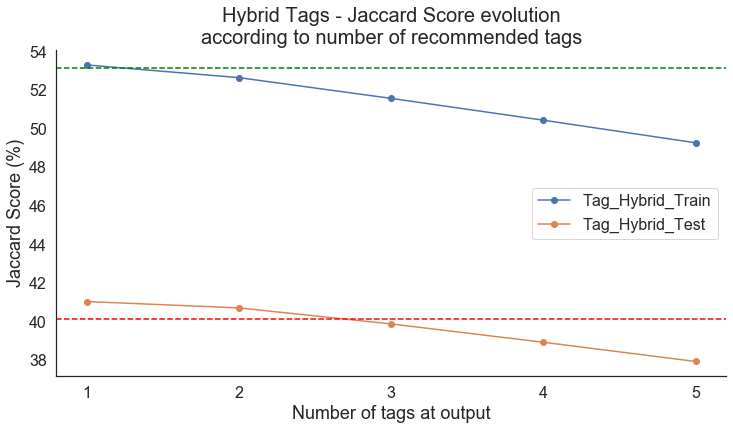

In [224]:
fig, ax = plt.subplots(figsize=(12, 6))
leg = ["Tag_Hybrid_Train", "Tag_Hybrid_Test"]
plt.plot(np.arange(5)+1, temp_v3_tr*np.ones(5)*100, marker='o')
plt.plot(np.arange(5)+1, temp_v3*np.ones(5)*100, marker='o')
plt.ylabel("Jaccard Score (%)", fontsize=18)
plt.xlabel("Number of tags at output", fontsize=18)
plt.title("Hybrid Tags - Jaccard Score evolution\
    \naccording to number of recommended tags", fontsize=20)
ax.tick_params(labelsize=16)
plt.xticks(np.arange(5)+1)
fig.patch.set_alpha(0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.axhline(y=53.16093858747887, color='green', linestyle='--')
plt.axhline(y=40.13471534463138, color='red', linestyle='--')
plt.legend(leg, fontsize=16)
plt.show()

In [210]:
# Using Weight on the 3 methods
def taggingv2(text, text_lem, number_of_tags):
    #count_vect
    text_cv = tf_vectorizer.transform([text])
    #tfv
    text_tfv = tfv.transform([text_lem])
    #whitespace token
    wtext = wstokenize(text_lem)
    
    #tagz_from_model
    threshold = 0.265
    tagz_from_model = supervised.predict_proba(text_tfv)
    tagz_from_model = (tagz_from_model>threshold).astype('int')
    if np.sum(tagz_from_model) < 1:
        threshold = np.sort(supervised.predict_proba(text_tfv))[0][-1]-1e-10
        tagz_from_model = supervised.predict_proba(text_tfv)
        tagz_from_model = (tagz_from_model>threshold).astype('int')
    tagz_from_model = mlb.inverse_transform(sparse.csr_matrix(tagz_from_model))[0]
    
    df_rez = pd.DataFrame(data=[tagz_from_model,
                                0.5316*np.ones(len(tagz_from_model))],
                          index=["tag", "value"])
    
    #tagz_from_it
    tagz_from_it = list([words for words in wtext if words in it_tags_dict])
    if len(tagz_from_it) > 0:
        for tag in tagz_from_it:
            ind = df_rez.shape[1]
            df_rez.at["tag",ind] = tag
            df_rez.at["value",ind] = 0.3194
    
    #tagz_from_topics
    tagz_from_topics = df_topic_keywords.iloc[np.argmax(lda_sk.transform(text_cv))].values
    temp = []
    for w in it_tags_dict:
        if w in tagz_from_topics:
            temp.append(w)
    tagz_from_topics = temp
    for tag in tagz_from_topics:
        ind = df_rez.shape[1]
        df_rez.at["tag",ind] = tag
        df_rez.at["value",ind] = 0.0976
    
    return(list(df_rez.T.groupby("tag").sum().sort_values(by="value",ascending=False).index)[:number_of_tags])

In [211]:
num_w = [1,
         2,
         3,
         4,
         5]
temp=[]
for num in num_w:
    tagz_v2 = [taggingv2(x, y, num) for x, y in zip(X_test, X_test_l)]
    print(num,jaccard_score(mlb.transform(tagz_v2),
                            y_test,
                            average='micro'))
    temp.append(jaccard_score(mlb.transform(tagz_v2),
                              y_test,
                              average='micro'))

1 0.25935459802275695
2 0.3443324631169935
3 0.3368372274523194


KeyboardInterrupt: 

In [81]:
# Using fine-tuned threshold run on the Test set + second fine-tuned threshold for the unpredicted cases
# Adding all the recommended tags from the three methods while keeping as first recommendations the tags from supervised
# Tags from LDA & Blunt are used if the required number of tags is not achieved
def tagging(text, text_lem, number_of_tags):
    #count_vect
    text_cv = tf_vectorizer.transform([text])
    #tfv
    text_tfv = tfv.transform([text_lem])
    #whitespace token
    wtext = wstokenize(text)
    
    #tagz_from_model
    threshold = 0.303
    tagz_from_model = supervised.predict_proba(text_tfv)
    tagz_from_model = (tagz_from_model>threshold).astype('int')
    if np.sum(tagz_from_model) < 1:
        threshold = np.max(supervised.predict_proba(text_tfv))*.89
        tagz_from_model = supervised.predict_proba(text_tfv)
        tagz_from_model = (tagz_from_model>threshold).astype('int')
    tagz_from_model = mlb.inverse_transform(sparse.csr_matrix(tagz_from_model))[0]
    
    #tagz_from_it
    tagz_from_it = list([words for words in wtext if words in it_tags_dict])
    if len(tagz_from_it) > 0:
        tagz_from_it = list(pd.Series(tagz_from_it).value_counts()[:number_of_tags].index)
    
    #tagz_from_topics
    tagz_from_topics = df_topic_keywords.iloc[np.argmax(lda_sk.transform(text_cv))].values
    temp = []
    for w in it_tags_dict:
        if (len(temp)<number_of_tags) & (w in tagz_from_topics):
            temp.append(w)
    tagz_from_topics = temp

    rez_tagz = tagz_from_model
    tagz_from_others=[]
    if len(tagz_from_it) > 0:
        for w in tagz_from_it:
            tagz_from_others.append(w)

    if len(tagz_from_topics) > 0:
        for w in tagz_from_topics:
            tagz_from_others.append(w)
            
    rez_tagz = list(rez_tagz)
    if len(tagz_from_others) > 0:
        tagz_from_others = list(pd.Series(tagz_from_others).value_counts().index)
        for w in tagz_from_others:
            if (w not in rez_tagz) & (len(rez_tagz)<number_of_tags):
                rez_tagz.append(w)

    return(rez_tagz)

In [73]:
xtext = df["Text"]
X_train, X_test, y_train, y_test = train_test_split(xtext,
                                                    ytags,
                                                    test_size=0.2,
                                                    random_state=42)
xtext = df["Text_lemmatized"]
X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(xtext,
                                                            ytags,
                                                            test_size=0.2,
                                                            random_state=42)

In [89]:
tagz_1 = [tagging(x,y,1) for x,y in zip(X_test,X_test_l)]
jaccard_score(mlb.transform(tagz_1),y_test,average='micro')

0.40327765521588405

In [91]:
tagz_2 = [tagging(x,y,2) for x,y in zip(X_test,X_test_l)]
jaccard_score(mlb.transform(tagz_2),y_test,average='micro')

0.38030002830455706

In [92]:
tagz_3 = [tagging(x,y,3) for x,y in zip(X_test,X_test_l)]
jaccard_score(mlb.transform(tagz_3),y_test,average='micro')

0.33785479251000167

In [93]:
tagz_4 = [tagging(x,y,4) for x,y in zip(X_test,X_test_l)]
jaccard_score(mlb.transform(tagz_4),y_test,average='micro')

0.28896446581447166

In [94]:
tagz_5 = [tagging(x,y,5) for x,y in zip(X_test,X_test_l)]
jaccard_score(mlb.transform(tagz_5),y_test,average='micro')

0.25105655226850404

### W2V Cross referencing

In [168]:
def tag_w2v(tagz, number_reco):
    #word2vec
    rez_w2v = pd.DataFrame()
    for u, w in enumerate(tagz):
        reco=[]
        if w in model_w2v.wv.vocab:
            for i, j in model_w2v.wv.most_similar(w,
                                                  topn=len(it_tags_dict)):
                if i in it_tags_dict:
                    reco.append(i)
            for l in range(len(reco[:number_reco])):
                rez_w2v.at[w, str("Word_"+str(l+1))]=reco[l]
    rez=[]
    for col in rez_w2v.columns:
        rez.extend(list(rez_w2v[col].value_counts().index))
    return(list(pd.Series(rez).value_counts().index))

In [104]:
tag_w2v(["python", "java"],7)

['numpy',
 'scipy',
 'oracle',
 'conda',
 'jvm',
 'anaconda',
 'flask',
 'eclipse',
 'django',
 'maven',
 'kotlin',
 'javafx',
 'pip']

## Outputs for API

In [105]:
xtext = df["Text"]

In [106]:
xtext_l = df["Text_lemmatized"]

In [107]:
ytarget = mlb.transform(df["Tags_in_IT_dict"])

In [108]:
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2)
tf_vectorizer.fit(xtext)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=0.95, max_features=None, min_df=2,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [112]:
xtarget = tf_vectorizer.transform(xtext)

In [113]:
tfv = TfidfVectorizer(min_df=1,
                      max_features=tfidf_max_feat,
                      ngram_range=(1, 1))
tfv.fit(xtext_l)
xtarget_l = tfv.transform(xtext_l) 

In [114]:
final_supervised = clf_lr
final_supervised.fit(xtarget_l,ytarget)

OneVsRestClassifier(estimator=LogisticRegression(C=10, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=1, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None,
                                                 penalty='elasticnet',
                                                 random_state=42, solver='saga',
                                                 tol=0.0001, verbose=0,
                                                 warm_start=False),
                    n_jobs=6)

In [115]:
final_unsupervised = lda_sk
final_unsupervised = lda_sk.fit(xtarget)

In [116]:
xtarget_tokenized = xtext_l.apply(wstokenize)
final_w2v = gensim.models.Word2Vec(sentences=X_train_tokenized,
                                   workers=6,
                                   seed=42)

In [117]:
import pickle

In [120]:
filename = "final_mlb.pkl"
pickle.dump(mlb, open(filename, "wb"))

In [121]:
filename = "final_tfvect.pkl"
pickle.dump(tf_vectorizer, open(filename,  "wb"))

In [122]:
filename = "final_tfidf.pkl"
pickle.dump(tfv, open(filename,  "wb"))

In [123]:
filename = "final_supervised.pkl"
pickle.dump(final_supervised, open(filename,  "wb"))

In [124]:
filename = "final_unsupervised.pkl"
pickle.dump(final_unsupervised, open(filename,  "wb"))

In [125]:
filename = "final_w2v.pkl"
pickle.dump(final_w2v, open(filename,  "wb"))